## Confined Voronoi Diagram

In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

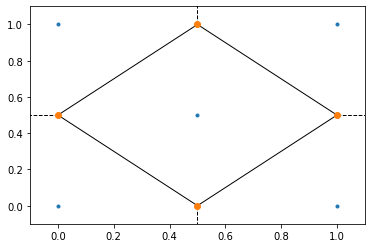

In [2]:
#Calculate Voronoi Polygons
square = [(0,0),(0,1),(1,1),(1,0),(0.5,0.5)]
vor  = Voronoi(square)
voronoi_plot_2d(vor)
plt.show()

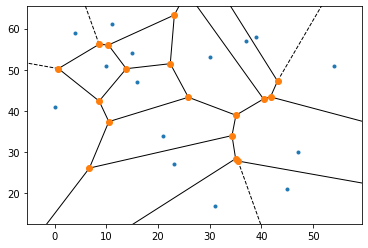

In [3]:
sites = np.random.randint(0, 63, (15,2))
sites

vor = Voronoi(sites)
voronoi_plot_2d(vor)
plt.show()

In [4]:
def voronoi_finite_polygons_2d(vor, radius = None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()
    
    new_ridge_vertices = []
    vor_ridge_vertices = vor.ridge_vertices
    
    for p in vor_ridge_vertices:
        if all(i >= 0 for i in p):
            new_ridge_vertices.append(p)
    
    center = vor.points.mean(axis = 0)
    if radius is None:
        radius = vor.points.ptp().max()
        
    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
            
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
            new_ridge_vertices.append([v2, len(new_vertices)-1])
            
        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices), new_ridge_vertices

## Testing for Various cases

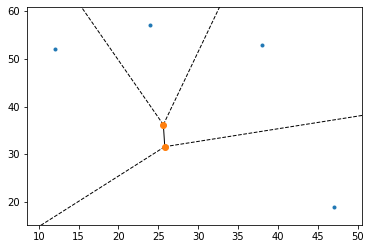

[[-5.06598783 -1.16089618]
 [69.30632652 43.09579231]
 [25.80459127 31.5806271 ]]
[[25.62711864 36.19491525]
 [25.80459127 31.5806271 ]
 [69.30632652 43.09579231]
 [37.9895694  79.4634929 ]]
[[-5.06598783 -1.16089618]
 [25.80459127 31.5806271 ]
 [25.62711864 36.19491525]
 [ 8.31942634 77.73337679]]
[[25.62711864 36.19491525]
 [37.9895694  79.4634929 ]
 [ 8.31942634 77.73337679]]


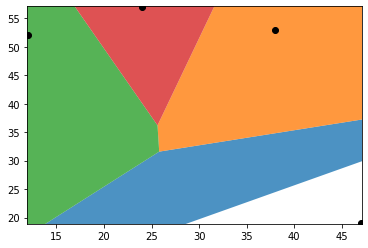

In [5]:

np.random.seed(1234)
sites = np.random.randint(0, 63, (4,2))

# Compute Voronoi tesselation
vor = Voronoi(sites)
voronoi_plot_2d(vor)
plt.show()

regions, vertices, new_ridge_vertices = voronoi_finite_polygons_2d(vor)
#     print('--')
#     print(regions)
#     print('--')
#     print(vertices)

for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.8)
    print(polygon)

plt.plot(sites[:,0], sites[:,1], 'ko')
# plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('voro.png')
plt.show()


- Doesn't work for 2 points. Needs minimum 3 points

In [6]:
def vertIdxToVal(vertices, ridge_vertices):
    '''
    Transforms the array of *indices* ridge_vertices into actual locations
    Input:
        vertices: Array containing the locations of all vertices
        ridge_Vertices: Array of indices (to vertices) of the vertices that make up the ith ridge
    Output:
        ridge_vertices_vals: 3D Array (n, 2, 2) of locations of the vertices that make up the n ridges
    '''
    ridge_vertices_val = []
    for idx_pair in ridge_vertices:
        ridge_vertices_val.append((vertices[idx_pair[0]].tolist(), vertices[idx_pair[1]].tolist()))
    unique_ridge_vertices_vals = np.unique(np.asarray(ridge_vertices_val), axis=0)
    
    return unique_ridge_vertices_vals

In [7]:
def drawLine(start, end):
    '''
    Implements Bresenham's line algorithm
    From http://www.roguebasin.com/index.php?title=Bresenham%27s_Line_Algorithm
    
    Input:
        - start: Tuple of coordinates for starting point (x,y)
        - end: Tuple of coordinates for end point (x,y)
    Output:
        - points: List of points that make up the line between the start and end points
    '''
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

def drawMultipleLines(ridgeVertices):
    '''
    Calls the drawLine method for each pair of vertices in the array ridgeVertices
    Input:
        - ridgeVertices: 3D array (n, 2, 2) where n is the number of ridges to draw,
                         the second dimension represents the two endpoints of the line, 
                         and the third dimension represents the x,y coordinates for a point
    Outpu:
        - lines: A list of lists, where each of the lists is the coordinates of the points
                 that make up each line
    
    '''
    
    lines = []
    for n in range(ridgeVertices.shape[0]):
        v1 = tuple(ridgeVertices[n][0])
        v2 = tuple(ridgeVertices[n][1])
        
        # Make the vertices integers instead of floats
        v1 = tuple(map(int, v1))
        v2 = tuple(map(int, v2))
        lines.append(drawLine(v1, v2))
    return lines

In [8]:
def plot2D(array):
    '''
    Plot a 2D array with a colorbar
    Input:
        - array: 2D array to plot
    '''
    plt.imshow(array)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()
    

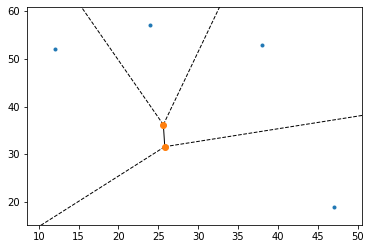

[[3, 2, 0], [1, 0, 4, 5], [6, 0, 1, 7], [1, 8, 9]]
[[25.80459127 31.5806271 ]
 [25.62711864 36.19491525]
 [69.30632652 43.09579231]
 [-5.06598783 -1.16089618]
 [69.30632652 43.09579231]
 [37.9895694  79.4634929 ]
 [-5.06598783 -1.16089618]
 [ 8.31942634 77.73337679]
 [37.9895694  79.4634929 ]
 [ 8.31942634 77.73337679]]


In [9]:
np.random.seed(1234)
sites = np.random.randint(0, 63, (4,2))
vor = Voronoi(sites)
voronoi_plot_2d(vor)
plt.show()

new_regions, new_vertices, new_ridge_vertices = voronoi_finite_polygons_2d(vor)
print(new_regions)
print(new_vertices)

In [10]:
ridge_verts = vertIdxToVal(new_vertices, new_ridge_vertices)
print(ridge_verts)
lines = drawMultipleLines(ridge_verts)

[[[25.62711864 36.19491525]
  [ 8.31942634 77.73337679]]

 [[25.62711864 36.19491525]
  [37.9895694  79.4634929 ]]

 [[25.80459127 31.5806271 ]
  [-5.06598783 -1.16089618]]

 [[25.80459127 31.5806271 ]
  [25.62711864 36.19491525]]

 [[25.80459127 31.5806271 ]
  [69.30632652 43.09579231]]]


In [11]:
x_min = 0
x_max = 63
y_min = 0
y_max = 63
valid_lines = []
for line in lines:
    temp_line = []
    for i,p in enumerate(line):
        if (p[0] >= x_min and p[0] <= x_max) and (p[1] >= y_min and p[1] <= y_max):
            temp_line.append(p)
    valid_lines.append(temp_line)

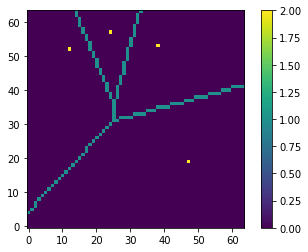

In [12]:
canvas = np.zeros((64,64))

for l in valid_lines:
    for p in l:
        canvas[p] = 1

for s in sites.tolist():
    canvas[tuple(s)] = 2

canvas = canvas.T
# canvas = np.rot90(canvas)
plot2D(canvas)

In [13]:
def intersection(lst1, lst2): 
    st1 = set(lst1)
    st2 = set(lst2)
    return st1.intersection(st2)

In [14]:
vertices = []
print(new_vertices)
for i in range(len(new_vertices)):
    vertices.append(tuple(map(int, new_vertices[i])))
print(vertices)

[[25.80459127 31.5806271 ]
 [25.62711864 36.19491525]
 [69.30632652 43.09579231]
 [-5.06598783 -1.16089618]
 [69.30632652 43.09579231]
 [37.9895694  79.4634929 ]
 [-5.06598783 -1.16089618]
 [ 8.31942634 77.73337679]
 [37.9895694  79.4634929 ]
 [ 8.31942634 77.73337679]]
[(25, 31), (25, 36), (69, 43), (-5, -1), (69, 43), (37, 79), (-5, -1), (8, 77), (37, 79), (8, 77)]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def vorarr(regions, vertices, width, height, dpi=4):
    fig = plt.Figure(figsize=(width/dpi, height/dpi), dpi=dpi)
    canvas = FigureCanvas(fig)
    ax = fig.add_axes([0,0,1,1])
    i = len(regions)
    # colorize
    for region in regions:
        polygon = vertices[region]
        i = i-1
        ax.fill(*zip(*polygon), color = str(i*0.02),alpha=1)
        

    ax.plot(points[:,0], points[:,1], 'ko')
    ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

    canvas.draw()
    return np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

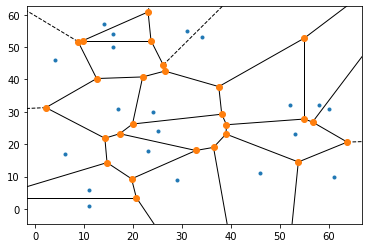

125


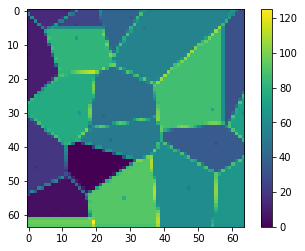

In [70]:
from scipy.spatial import Voronoi
import cv2

# get random points
points = np.random.randint(0, 63, (20,2))

# compute Voronoi tesselation
vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()

# voronoi_finite_polygons_2d function from https://stackoverflow.com/a/20678647/425458
regions, vertices, ridges = voronoi_finite_polygons_2d(vor, 100000)

# convert plotting data to numpy array
arr = vorarr(regions, vertices, width=64, height=64)
gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
# plot the numpy array
# cv2.imshow('image', gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# for i in range(64):
#     for j in range(64):
#         if gray[i][j] == 100:
#             gray[i][j] = 255
#         else:
#             gray[i][j] = 0

plt.imshow(gray)
print(np.amax(gray))
plt.colorbar()
plt.savefig('converted.png')
# print(arr)

In [77]:
threshold = 1500
value = np.arange(0,np.amax(gray))
# print(value)
for i in value:
    occurrences = np.count_nonzero(gray == i)
    if occurrences<=threshold and occurrences>=150:
        print(occurrences)
        print('Region with value {} is small enough to be picked up' .format(i))

152
Region with value 0 is small enough to be picked up
199
Region with value 36 is small enough to be picked up
245
Region with value 46 is small enough to be picked up
168
Region with value 51 is small enough to be picked up
381
Region with value 56 is small enough to be picked up
352
Region with value 61 is small enough to be picked up
254
Region with value 77 is small enough to be picked up
186
Region with value 82 is small enough to be picked up
371
Region with value 87 is small enough to be picked up
286
Region with value 92 is small enough to be picked up
